# Synthesized Observations

We can employ the Maria software to generate synthetic mock observations of bolometric arrays mounted on large single-dish telescopes. We developed a wrapper known as "Simulation," which emulates telescopes such as ACT, Toltec, GBT, and AtLAST. The wrapper produces time-ordered domain (TOD) data. By simulating distinct atmospheric layers that correspond to the designated site within the simulation, we enable the mock-array to sweep across the actual celestial sky while encountering varying atmospheric conditions in between. Consequently, the TODs produced will be a composite of the genuine sky, atmospheric effects, and detector noise (based on the white noise measurements of ACT). Through this approach, the process of generating mock-observations also yields filtered observations, effectively dampening the sensitivity to larger scales due to the atmospheric interferences.

This tutorial will explain you how to setup the simulation tool an make your own mock-observations.

In [2]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

In [3]:
from maria import Simulation
from maria import mappers

## Set up the Simulation
The "Simulation" class offers the flexibility to incorporate various inputs tailored to atmospheric simulations. For instance, it allows the creation of an observatory like 'AtLAST,' situated at the APEX site. Similarly, if the intention is to simulate Mustang-2 observations but, for instance, under less favorable weather conditions, adjusting the 'quantiles' parameter within the Simulation keywords can achieve this.

Furthermore, the Simulation class accommodates the exploration of how different scanning strategies affect the filtering of large scales. Standard strategies, such as the back-and-forth or Daisy scan patterns, have been implemented for this purpose. This feature enables the study of how the chosen scanning approach influences the overall large-scale filtering.

For comprehensive documentation regarding all available keywords, we recommend consulting the detailed documentation provided at [insert documentation reference]. Now, let's proceed to initiate an example of a mock observation involving a significant galaxy cluster merger event at redshift 1 observed via the SZ effect, utilizing the Mustang-2 instrument:

### Initialize
First we need to initialize the telescope and weather conditions

In [37]:
sim = Simulation(

    # Mandatory minimal weither settings
    # ---------------------
    array     = 'MUSTANG-2',       # Array type
    pointing  = 'DAISY_2deg',      # Scanning strategy 
    site      = 'GBT',             # Site
    atm_model = 'linear_angular',  # The atmospheric model, set to None if you want a noiseless observation.
    # atm_model = None,              # The atmospheric model, set to None if you want a noiseless observation.
    
    # True sky input
    # ---------------------
    map_file     = "../../../maps/protocluster.fits",                     # Input files must be a fits file.
                                                                          # map_file can also be set to None 
                                                                          # if are only interested in the noise
    map_center   = (4, 10.5),                                             # RA & Dec in degree

    # Defeault Observational setup
    # ----------------------------
    integration_time = 600,         # seconds
    pointing_center = (4, 10.5),    # degrees
    pointing_frame  = "ra_dec",     # frame
    pointing_throws = (0.25, 0.25),   # How large the scanning pattern is in degree

    # Additional inputs:
    # ----------------------
    quantiles    = {'column_water_vapor' : 0.5},    # Weather conditions specific for that site
    map_units    = 'Jy/pixel',                      # Kelvin Rayleigh Jeans (KRJ, defeault) or Jy/pixel 
    map_inbright = -1.9787098e-8,                   # Linearly scale the map to have this peak value.
    map_res      = 0.25/60/60,                      # degree, overwrites header information
)

Computing weights: 100%|██████████| 4/4 [00:00<00:00, 109.94it/s]


### Get the TODs
To get the time ordered domain (TOD) data you simply need to run the script. The tod is an object which has the time, and coordinates stored together with the intensity of each scan per detector. The units of the intensities are always outputted in surface brightness temperature units: Kelvin Rayleigh Jeans.

In [38]:
tod = sim.run()

Sampling layers: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


In [39]:
# save the tods

Here are some usefull visualizations:

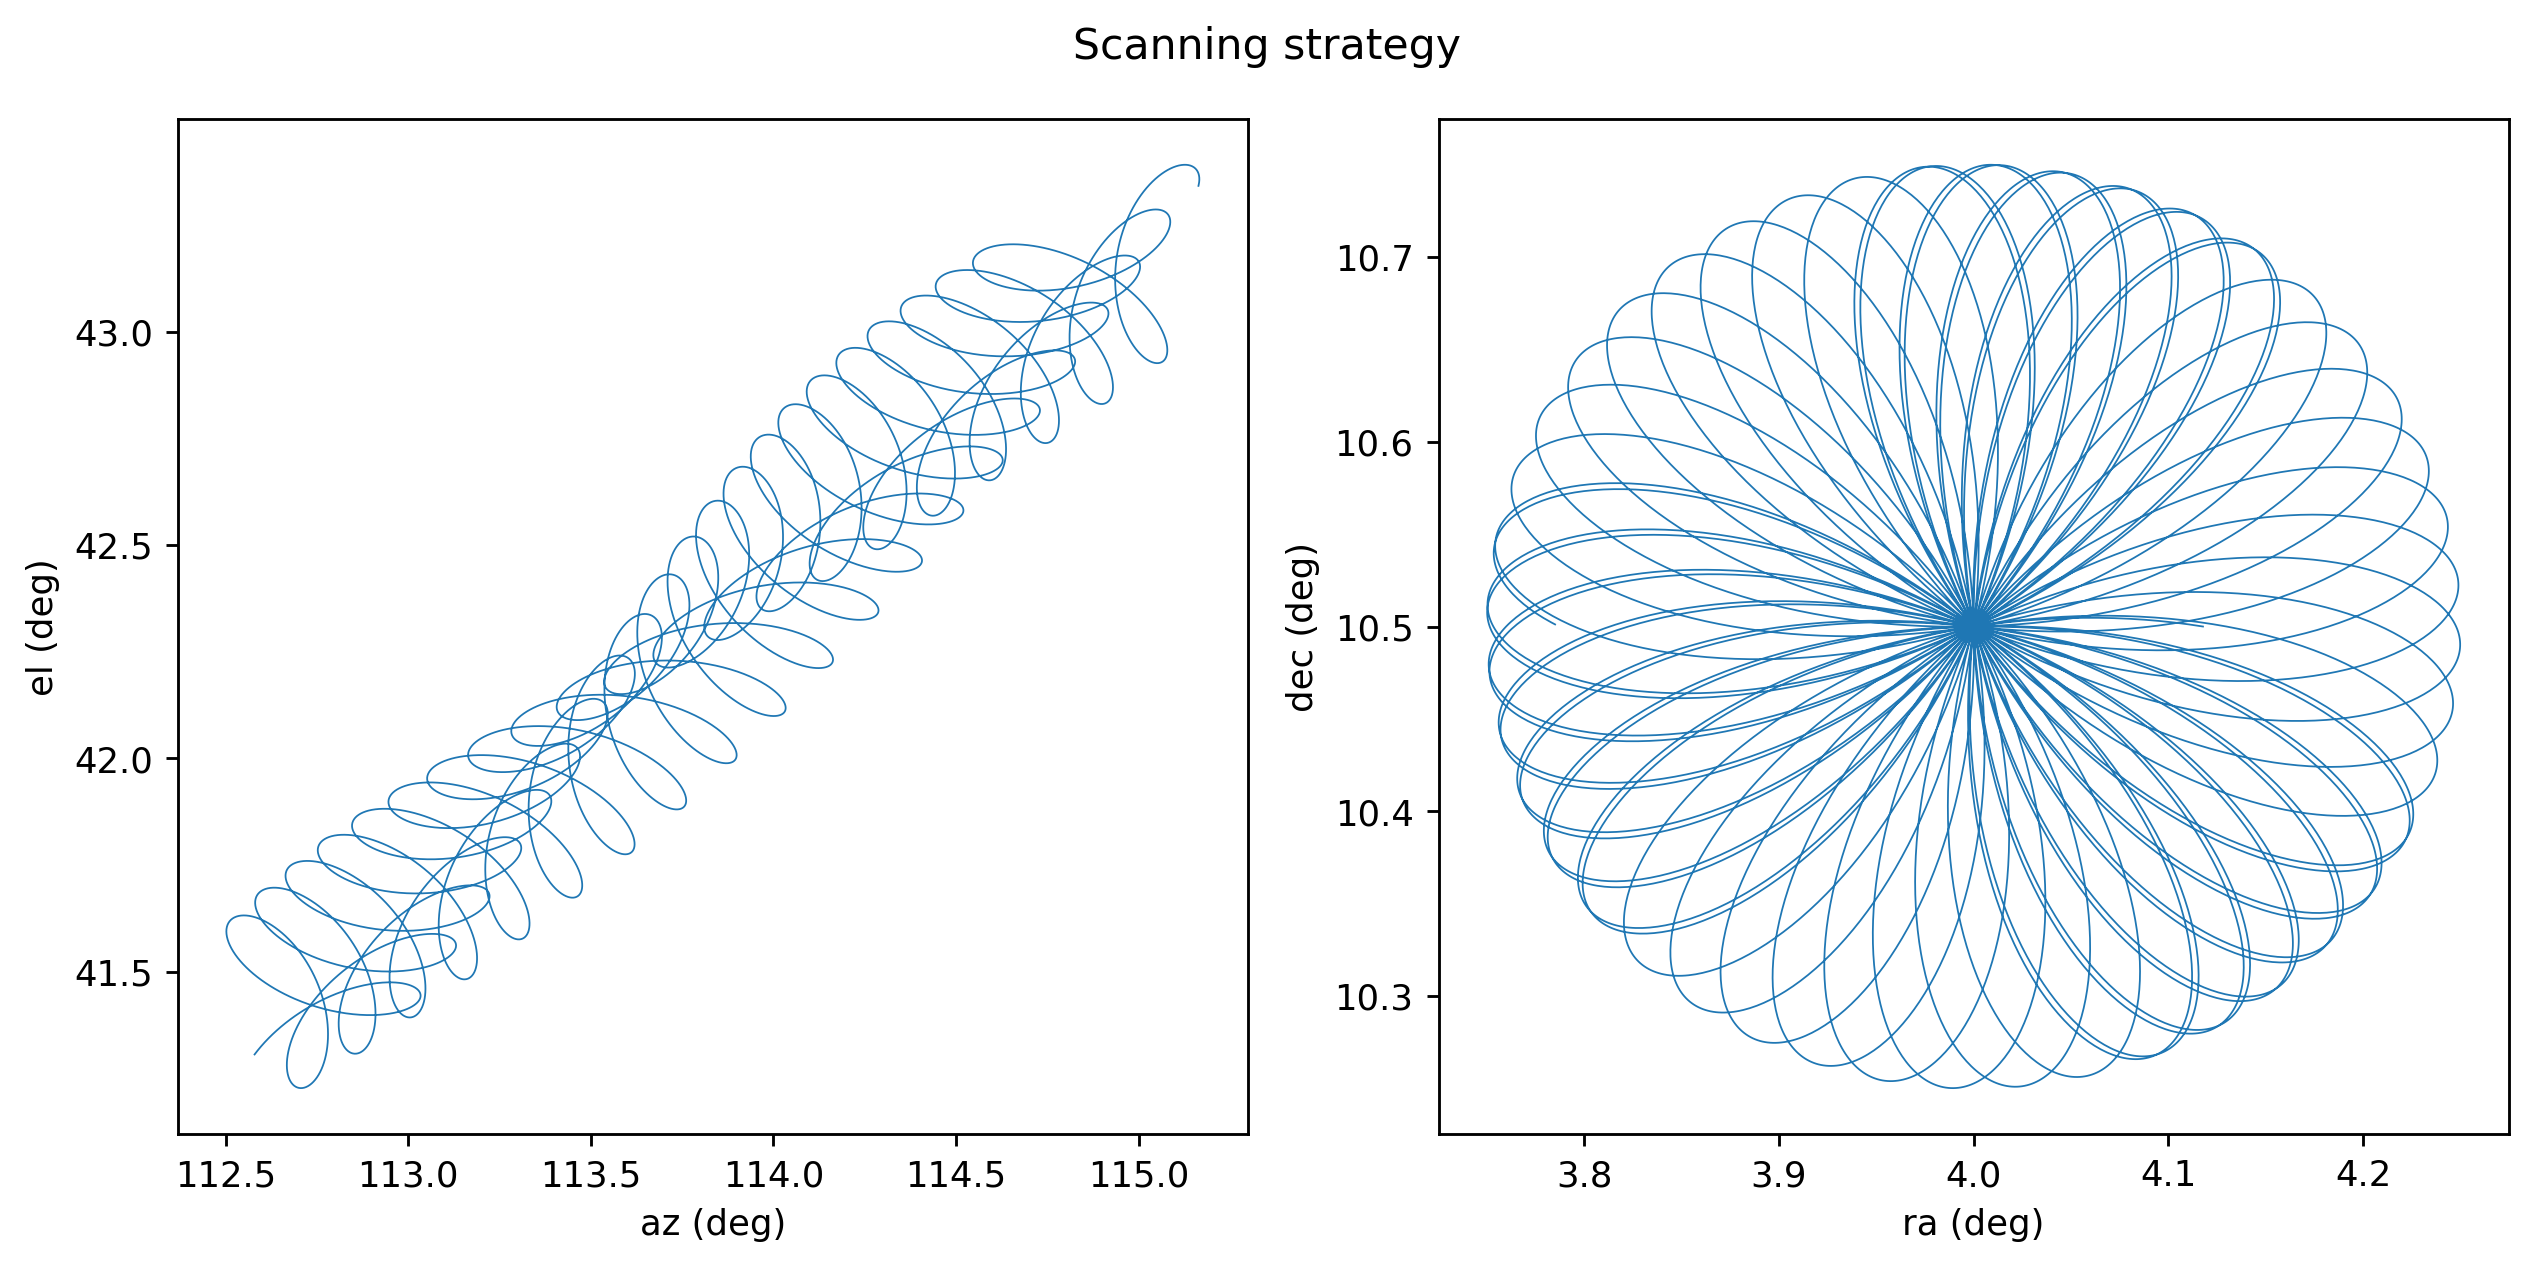

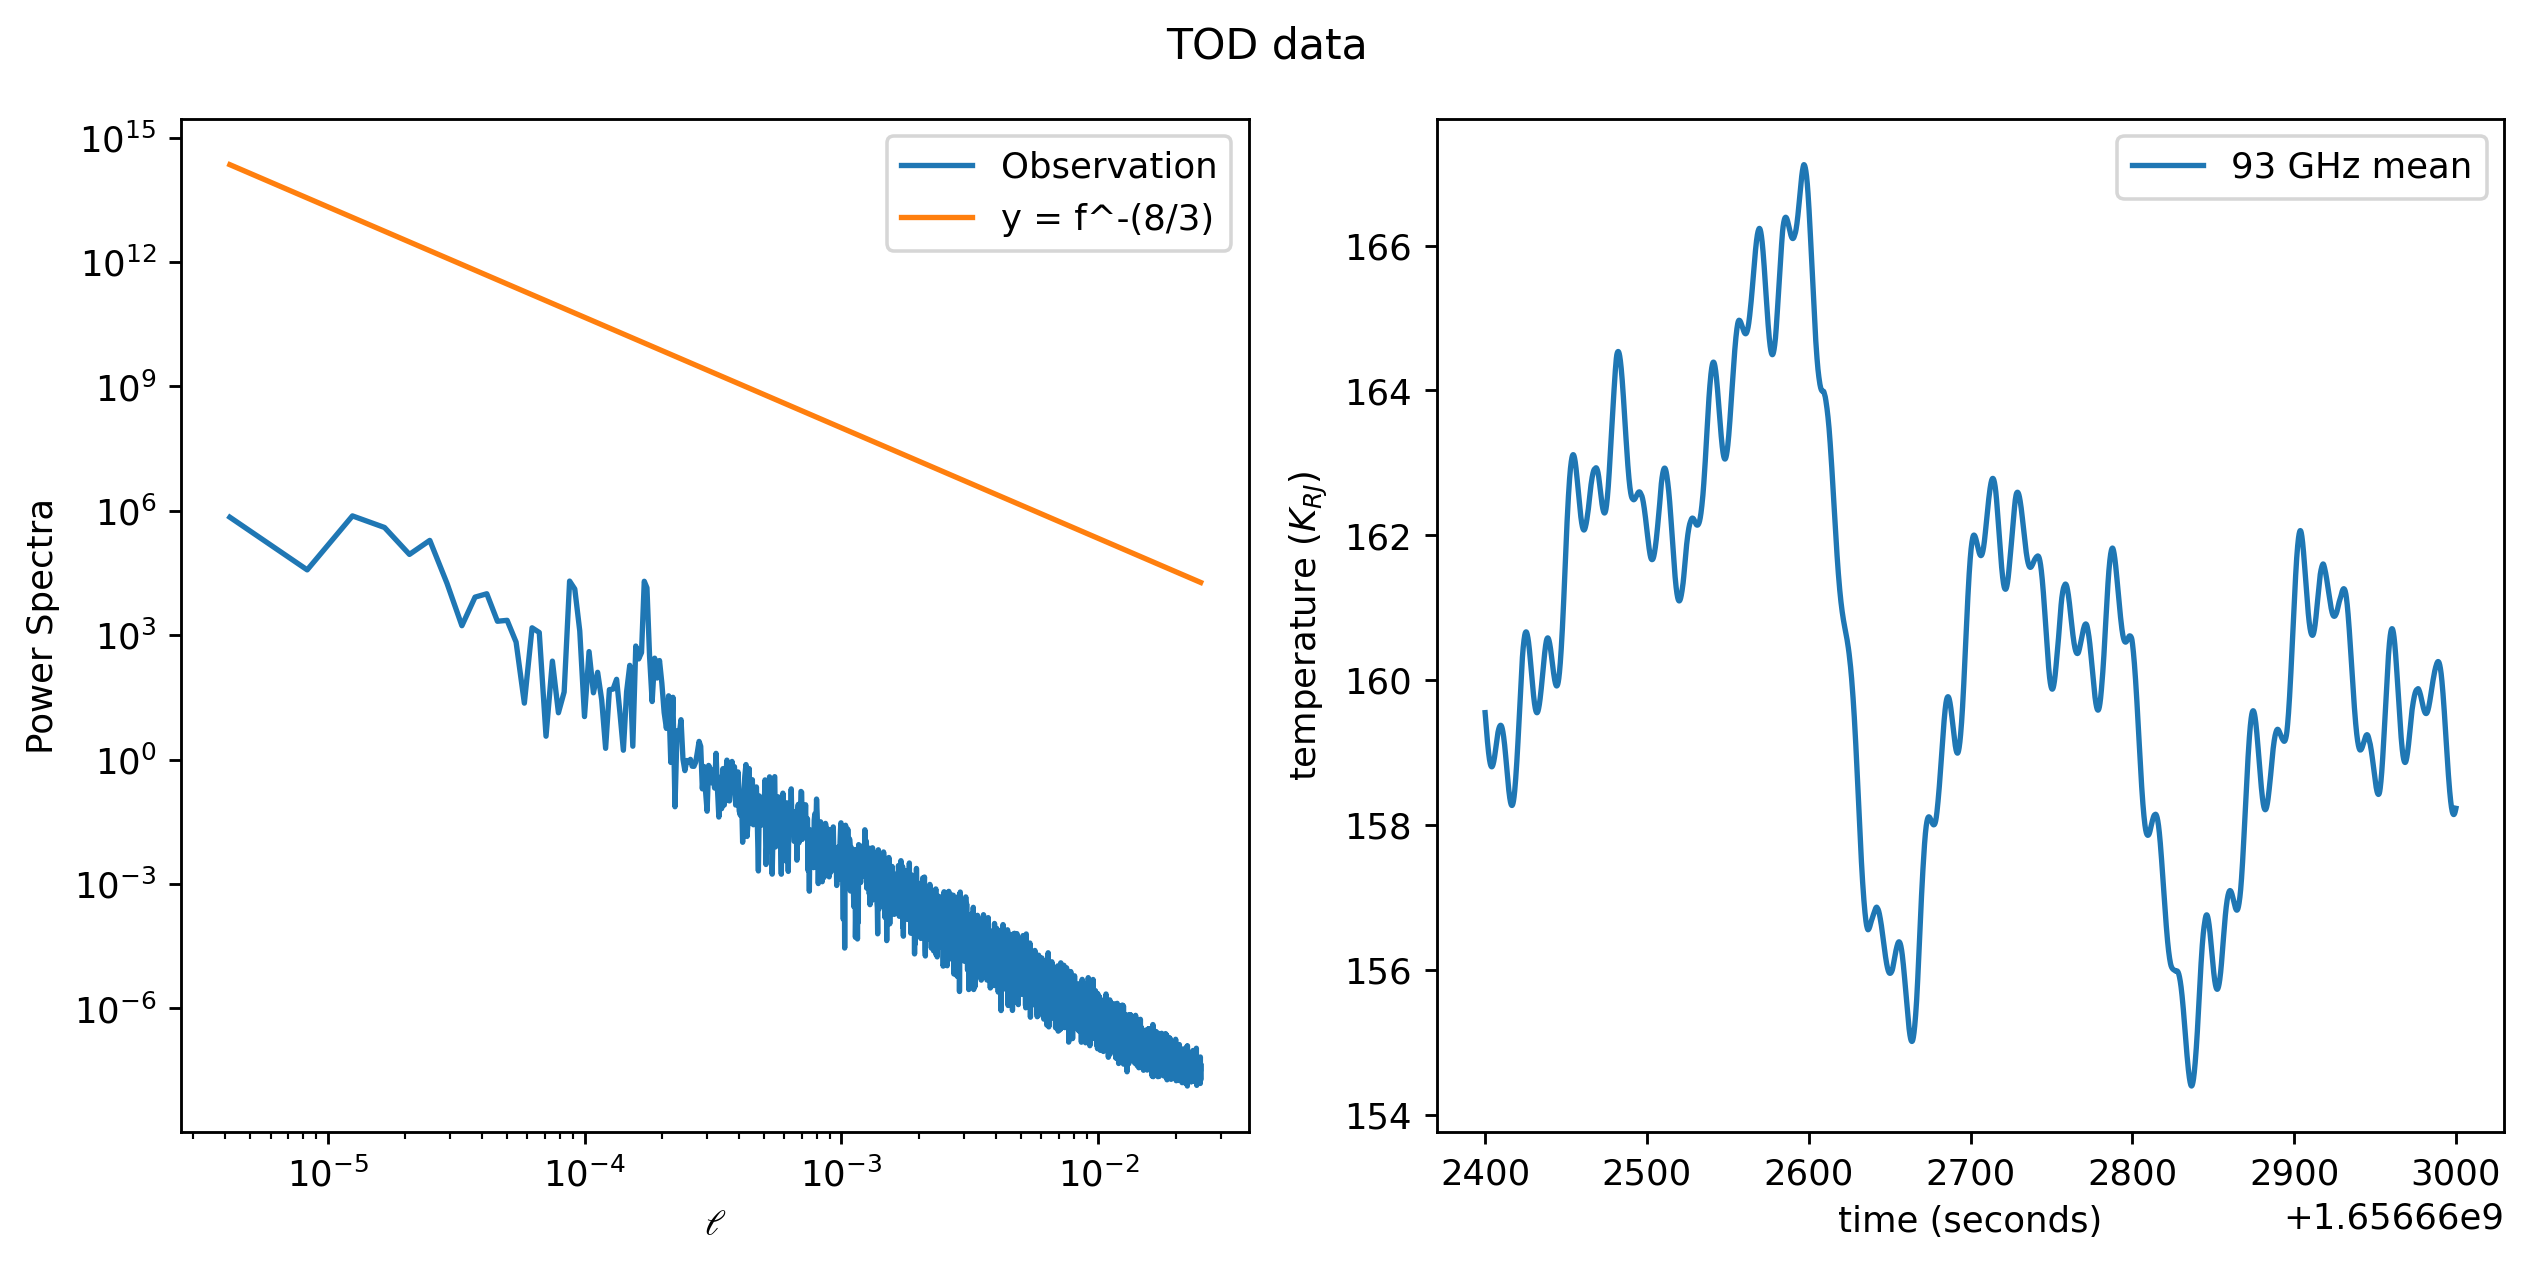

In [41]:

# visualize scanning patern
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=256, tight_layout=True)
fig.suptitle('Scanning strategy')
axes[0].plot(np.degrees(tod.az), np.degrees(tod.el), lw=5e-1)
axes[0].set_xlabel("az (deg)"), axes[0].set_ylabel("el (deg)")
axes[1].plot(np.degrees(tod.ra), np.degrees(tod.dec), lw=5e-1)
axes[1].set_xlabel("ra (deg)"), axes[1].set_ylabel("dec (deg)")
plt.show()

# visualize powerspectrum
f, ps = sp.signal.periodogram(tod.data, fs=tod.time[1]-tod.time[0], window="tukey")

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=256, tight_layout=True)
fig.suptitle('TOD data')
axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Observation")
axes[0].plot(f[1:], f[1:] ** (-8 / 3), label="y = f^-(8/3)")
axes[0].set_xlabel(r"$\mathscr{l}$"), axes[0].set_ylabel("Power Spectra")
axes[0].loglog(), axes[0].legend()

for uib, uband in enumerate(np.unique(tod.dets.band)):
    band_mask = tod.dets.band == uband
    band_mean = tod.data[band_mask].mean(axis=0)
    axes[1].plot(tod.time, band_mean, label=f'{int(uband[1:])} GHz mean')

axes[1].set_xlabel('time (seconds)'), axes[1].set_ylabel(r'temperature ($K_{RJ}$)')
axes[1].legend()

plt.show()

## Mapping the TODs
To create images from the TODs, you'll need a mapper. While you can develop your own mapper using the saved TODs, we've also included a pre-implemented option for your convenience. This built-in mapper follows a straightforward approach: it combines data into bins, removes the first eigenmode, and arranges the data on a grid. Notably, the mapper is designed to effectively eliminate correlated atmospheric noise present among different scans, thereby enhancing the quality of the resulting images.

An example of running a mapper on the tod works as follows:

In [42]:
mapper = mappers.RawBinMapper(resolution=np.radians(0.25/60))
mapper.add_tods(tod)
mapper.run()

/Users/jvanmarr/Documents/GitHub/maria/maria/mappers.py:113: RuntimeWarning: invalid value encountered in true_divide
  self.maps[band] = self.map_sums[band] / self.map_cnts[band]


The mapper uses the Array information specificied above. Below you can find the detector positions in the plane of the sky. Then, the figure next to it, shows how many time a detector passed a certain pixel on the map which is related to the sensitivity of map and the scanning strategy specialized above. 

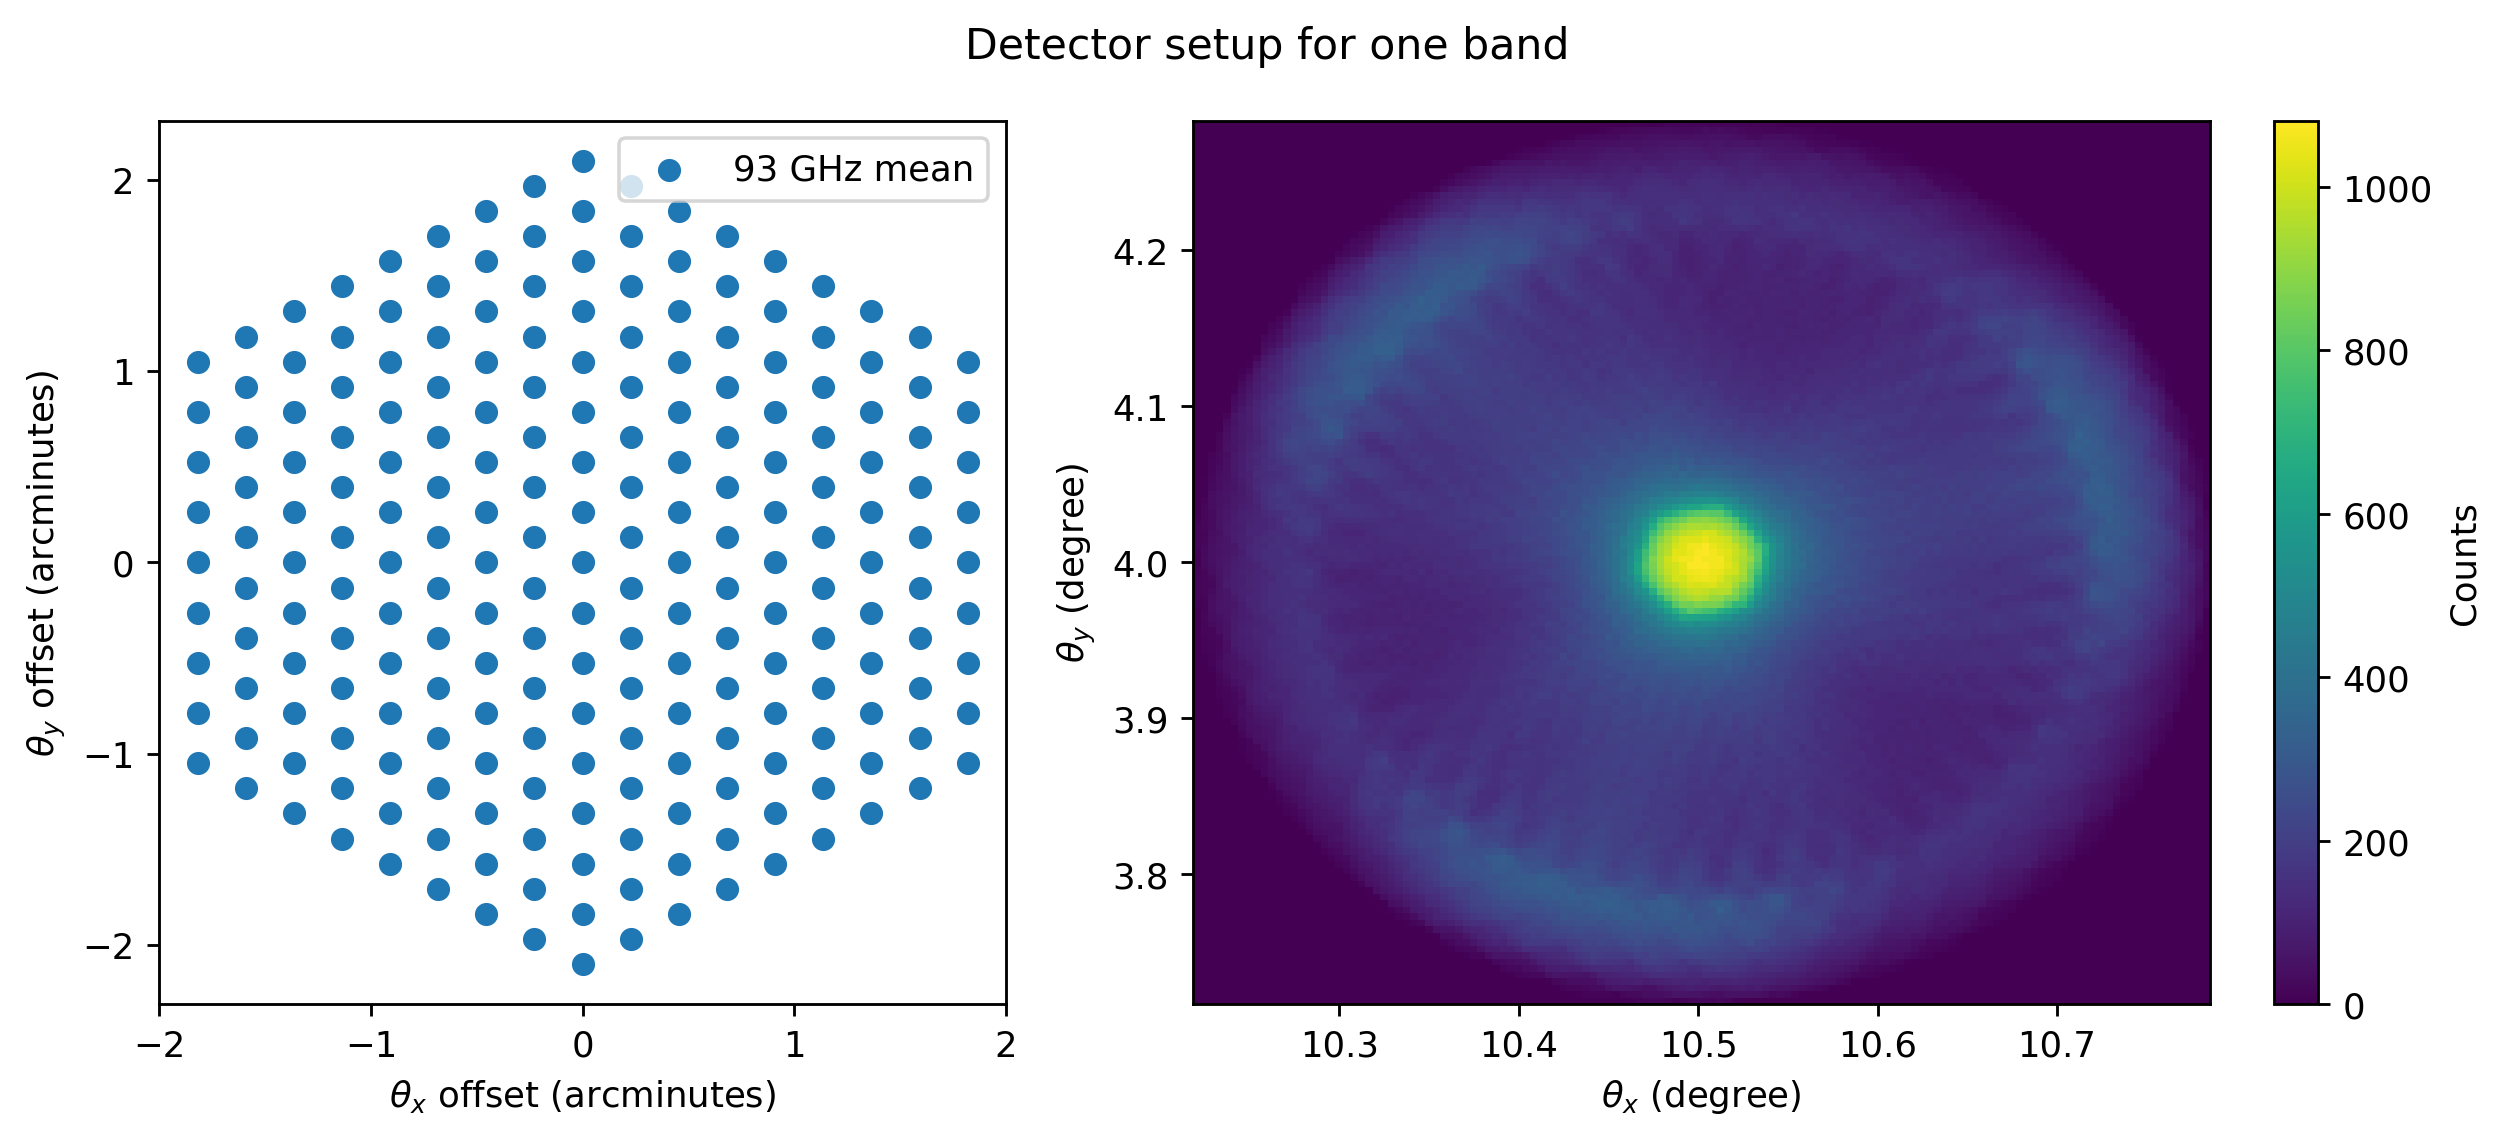

In [44]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), dpi=256, tight_layout=True, gridspec_kw={'width_ratios': [1,1.5]})
fig.suptitle('Detector setup for one band')

for uband in sim.array.ubands:

    band_mask = sim.array.band == uband

    axes[0].scatter(60 * np.degrees(sim.array.sky_x[band_mask]), 
                    60 * np.degrees(sim.array.sky_y[band_mask]),
                    label=f'{int(uband[1:])} GHz mean', lw=5e-1)
axes[0].set_xlabel(r'$\theta_x$ offset (arcminutes)'), axes[0].set_ylabel(r'$\theta_y$ offset (arcminutes)')
axes[0].legend()

xs, ys = np.meshgrid(np.degrees((mapper.dec_bins[1:] + mapper.dec_bins[:-1])/2),
                     np.degrees((mapper.ra_bins[1:] + mapper.ra_bins[:-1])/2))
       
im = axes[1].pcolormesh(
                   xs, 
                   ys, 
                   mapper.map_cnts[tod.dets.band[0]], 
                   label = 'Photon counts in band '+ tod.dets.band[0])

axes[1].set_xlabel(r'$\theta_x$ (degree)'), axes[1].set_ylabel(r'$\theta_y$ (degree)')
cbar = plt.colorbar(im, ax = axes[1])
cbar.set_label('Counts')
plt.show()

# Visualzing the maps
As interesting as the detector setup, power spectra, and time series are, the goal of this module is to create synthetic observations. Here, we will take you through how to retrieve the scientific data and measure the noise properties of the observations. 

First, we can save the maps to fits files, simply by running ```mapper.save()```. This will output the fits and update the header according to the newly set observations.

In [45]:
sim.save_maps(mapper)

AttributeError: 'NoneType' object has no attribute 'map_data'

Let's show what we got. On the left we show the input map

In [46]:
from astropy.io import fits
from astropy.wcs import WCS

../../../maria/outputs/atm_model_linear_angular_file_protocluster.fits


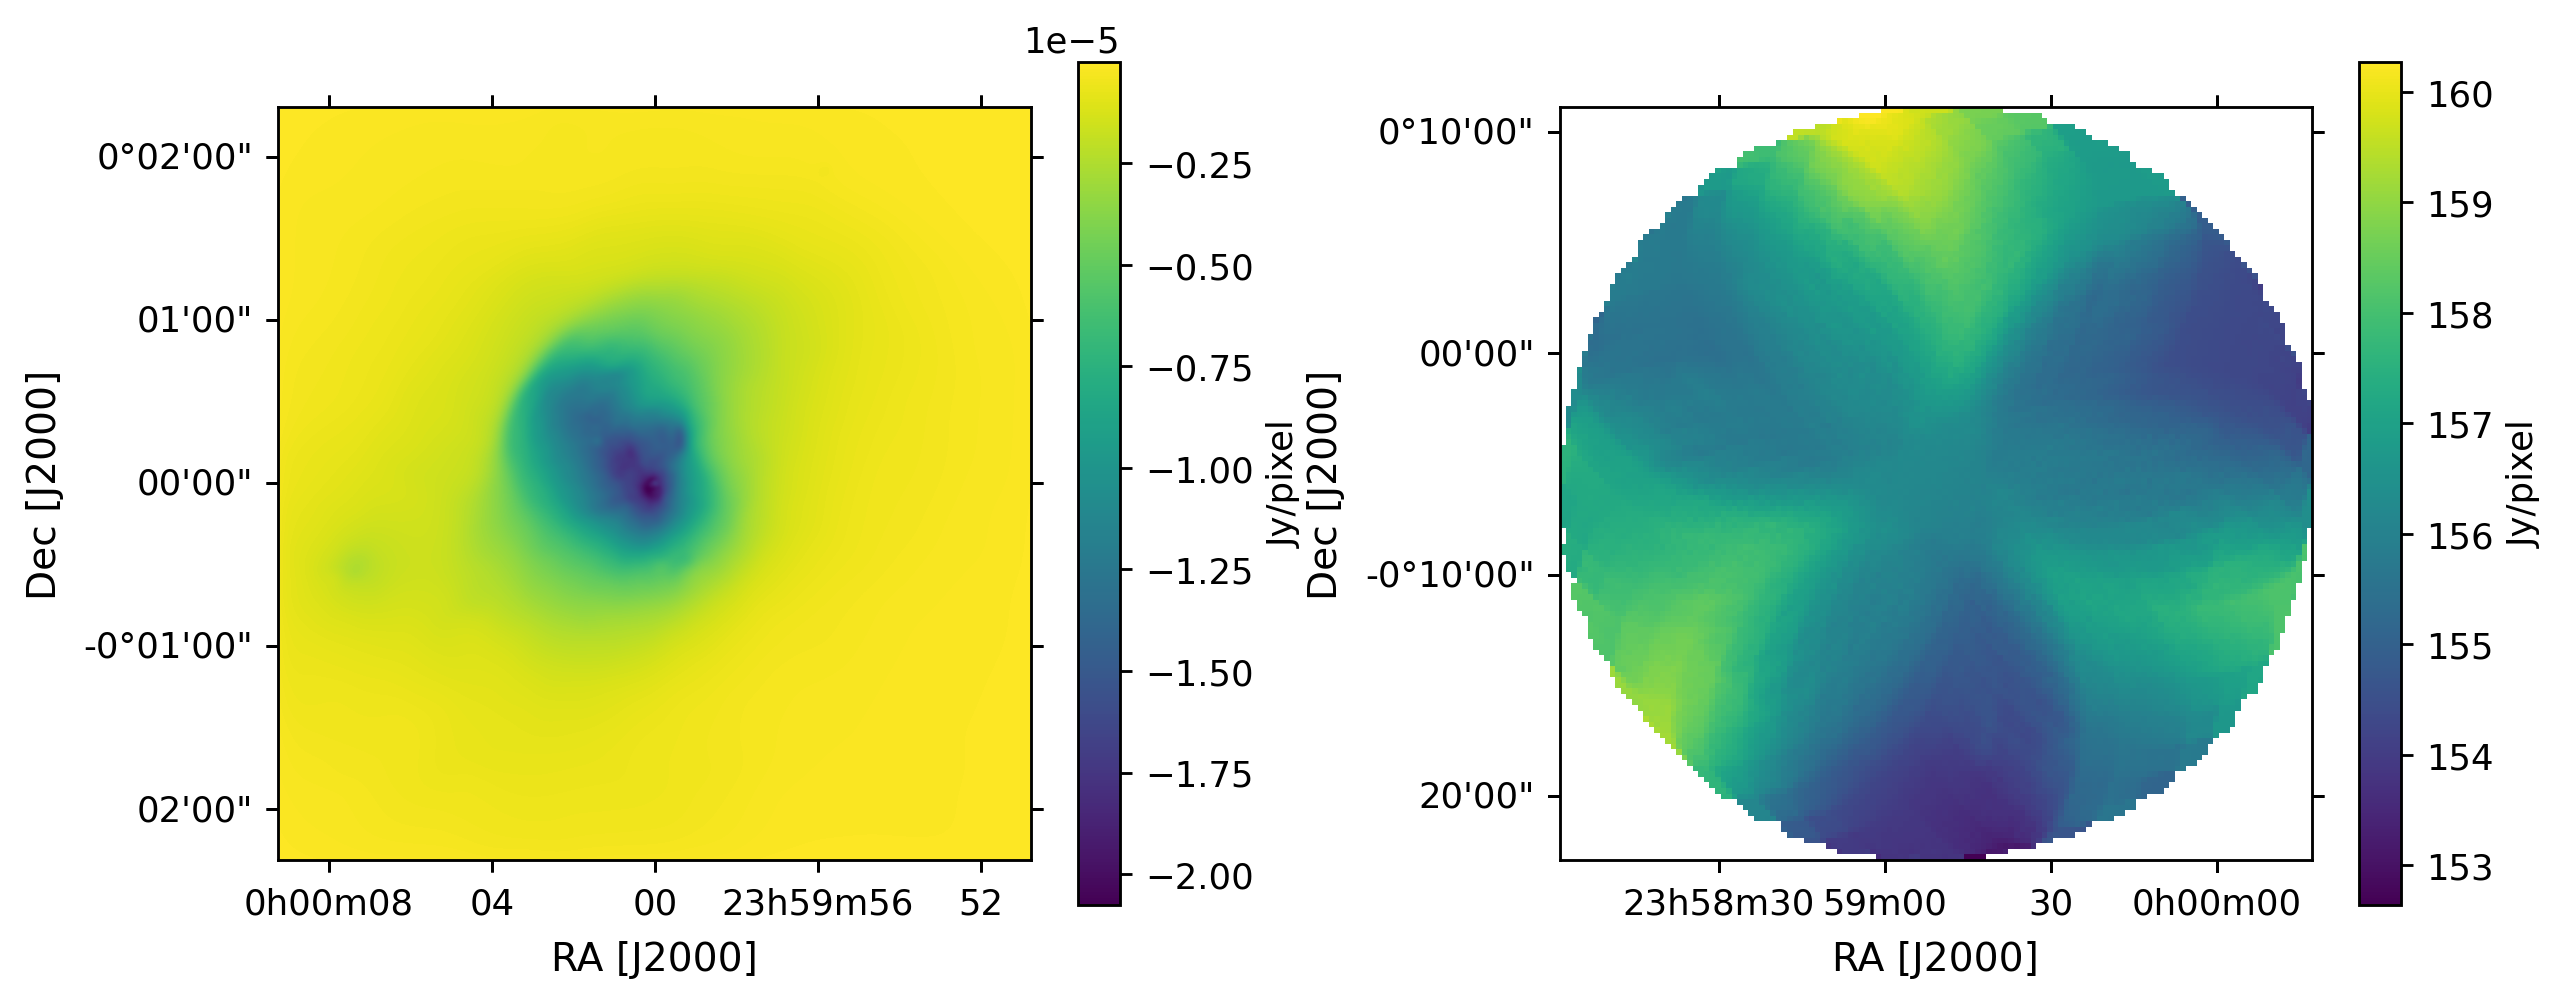

In [47]:
fig = plt.figure(dpi = 256, tight_layout=True)
fig.set_size_inches(10, 5, forward=True)

# - Input figure
inputfile = "../../../maps/protocluster.fits"
hdu = fits.open(inputfile)
wcs_input = WCS(hdu[0].header, naxis = 2)  

# - Plot
ax = plt.subplot(1,2,1, projection=wcs_input)
im = ax.imshow(hdu[0].data*100)
cbar = plt.colorbar(im, ax = ax, shrink = 0.7)
cbar.set_label('Jy/pixel')

ra, dec = ax.coords
ra.set_major_formatter('hh:mm:ss')
dec.set_major_formatter('dd:mm:ss')
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

# - Mock observation
outputfile = "../../../maria/outputs/atm_model_linear_angular_file_protocluster.fits"
print(outputfile)
hdu = fits.open(outputfile)
wcs_output = WCS(hdu[0].header, naxis = 2)  

# - Plot
ax = plt.subplot(1,2,2, projection=wcs_output)
im = ax.imshow(hdu[0].data)
cbar = plt.colorbar(im, ax = ax, shrink = 0.7)
cbar.set_label('Jy/pixel')

ra, dec = ax.coords
ra.set_major_formatter('hh:mm:ss')
dec.set_major_formatter('dd:mm:ss')
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))


# Specializing your observation set
If you wanna alter the observations, you can just give it additional kwargs:

## Change the Telescope